### Imports and loads

In [1]:
import sys, yaml
sys.path.append('../lib')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit

In [2]:
from spdc_model_utils import countProbaIdler, countProbaSignal
from spdc_model_utils import countProbaS1S2, countProbaiS, countProbai12
from spdc_model_utils import g2_0

In [3]:
lambda_s0 = pd.read_csv('../data/schmidt_eigenvalues.csv', index_col=0)
df = pd.read_csv('../data/measured_rates_etaAndMu.csv')
with open('../data/efficiencies_estimation.yml', 'r') as fileIn:
    eta0 = yaml.load(fileIn, Loader=yaml.Loader)
for k in eta0.keys():
    eta0[k[-1]] = eta0.pop(k)

### Definitions

In [52]:
class FitResults:
    def __init__(self, mu=df['mu0'], mu_err=df['mu0_err'], eta=eta0, 
                 rate=1e6, rate_err=1.3,
                 k=2.71, k_err=0.2, 
                 modLambda=0, modLambda_err=0):
        self.mu = mu
        self.mu_err = mu_err
        self.rate = rate
        self.rate_err = rate_err
        self.eta = eta
        self.k = k
        self.k_err = k_err
        self.modLambda = modLambda
        self.modLambda_err = modLambda_err

In [53]:
def getLambda(modLambda):
    if modLambda == 0:
        return lambda_s0['central']
    else:
        raise

In [105]:
def plotSingleDetectors(data=df, fr=None):
    lambdas = getLambda(fr.modLambda)
    plt.rcParams.update({'font.size': 16})
    fig1, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    axs[0,0].set_title('Idler detector')
    axu = axs[0,0]
    axd = axs[1,0]
    
    detectors = {'Ci_tot': 'Threshold', 'Ci_single': 'PNR'}
    kappa = {'Ci_tot': 0, 'Ci_single': fr.k}
    for i, (n, tag) in enumerate(detectors.items()):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        yModel = countProbaIdler(fr.mu, fr.eta['i'][0], kappa[n], lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaIdler(fr.mu+dx, fr.eta['i'][0], kappa[n], lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    axs[0,1].set_title('Signal detectors')
    axu = axs[0,1]
    axd = axs[1,1]
    
    detectors = [['C1_tot', 'Signal 1'], ['C2_tot', 'Signal 2']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i+2), label=tag)
        yModel = countProbaSignal(fr.mu, fr.eta[str(i+1)][0], lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i+2), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaSignal(fr.mu+dx, fr.eta[str(i+1)][0], lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i+2))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()

In [106]:
def plotTwofold(data=df, fr=None):
    lambdas = getLambda(fr.modLambda)
    plt.rcParams.update({'font.size': 16})
    fig1, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    axs[0,0].set_title('Threshold detectors')
    axu = axs[0,0]
    axd = axs[1,0]
    
    detectors = {'Ci1_thr': 'Idler & S1', 'Ci2_thr': 'Idler & S2', 'C12': 'S1 & S2'}
    for i, (n, tag) in enumerate(detectors.items()):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        
        def model(x):
            if n.startswith('Ci1'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['1'][0], k=0, lambdas=lambdas)
            elif n.startswith('Ci2'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['2'][0], k=0, lambdas=lambdas)
            elif n.startswith('C12'):
                return countProbaS1S2(x, fr.eta['1'][0], fr.eta['2'][0], lambdas=lambdas)
                    
        yModel = model(fr.mu)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - model(fr.mu+dx)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    axs[0,1].set_title('PNR detector')
    axu = axs[0,1]
    axd = axs[1,1]
    
    detectors = [['Ci1_pnr', 'Idler & S1'], ['Ci2_pnr', 'Idler & S2']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i+2), label=tag)
        yModel = countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i+2), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i+2))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()

In [ ]:
def plot_g2_0(data=df, fr=None, figsize=(8,6)):
    lambdas = getLambda(fr.modLambda)
    plt.rcParams.update({'font.size': 18})
    fig1, (axu, axd) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    detectors = {'Ci1_thr': 'Idler & S1', 'Ci2_thr': 'Idler & S2', 'C12': 'S1 & S2'}
    for i, (n, tag) in enumerate(detectors.items()):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i), label=tag)
        
        def model(x):
            if n.startswith('Ci1'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['1'][0], k=0, lambdas=lambdas)
            elif n.startswith('Ci2'):
                return countProbaiS(x, fr.eta['i'][0], fr.eta['2'][0], k=0, lambdas=lambdas)
            elif n.startswith('C12'):
                return countProbaS1S2(x, fr.eta['1'][0], fr.eta['2'][0], lambdas=lambdas)
                    
        yModel = model(fr.mu)
        axu.plot(fr.mu, yModel, color='C'+str(i), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - model(fr.mu+dx)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    axs[0,1].set_title('PNR detector')
    axu = axs[0,1]
    axd = axs[1,1]
    
    detectors = [['Ci1_pnr', 'Idler & S1'], ['Ci2_pnr', 'Idler & S2']]
    for i, (n, tag) in enumerate(detectors):
        yData = data[n]/fr.rate
        yerr = yData*np.hypot(data[n+'_err']/data[n], fr.rate_err/fr.rate)
        axu.errorbar(fr.mu, yData, xerr=fr.mu_err, yerr=yerr, ls='none', marker='.', color='C'+str(i+2), label=tag)
        yModel = countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        axu.plot(fr.mu, yModel, color='C'+str(i+2), ls='--')
        
        dx = fr.mu*0.1
        dy = yModel - countProbaiS(fr.mu, fr.eta['i'][0], fr.eta[str(i+1)][0], k=fr.k, lambdas=lambdas)
        sig = np.hypot(yerr, fr.mu_err*dy/dx)
        pull = (yData - yModel)/sig
        axd.plot(fr.mu, pull, ls='none', marker='o', mfc='none', color='C'+str(i+2))
    axu.grid()
    axd.grid()
    axu.set_ylabel('Probability')
    axd.set_ylabel(r'Pull [$\sigma$]')
    axd.set_xlabel(r'$\mu$')
    axu.legend(loc='best')
    
    yd, yu = axd.get_ylim()
    axd.set_ylim(max(yd, -5), min(yu, 5))
    
    fig1.tight_layout()

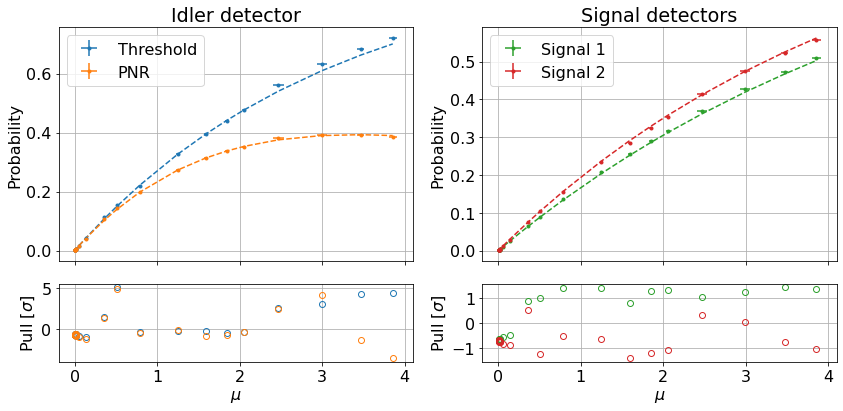

In [108]:
plotSingleDetectors(fr=FitResults())

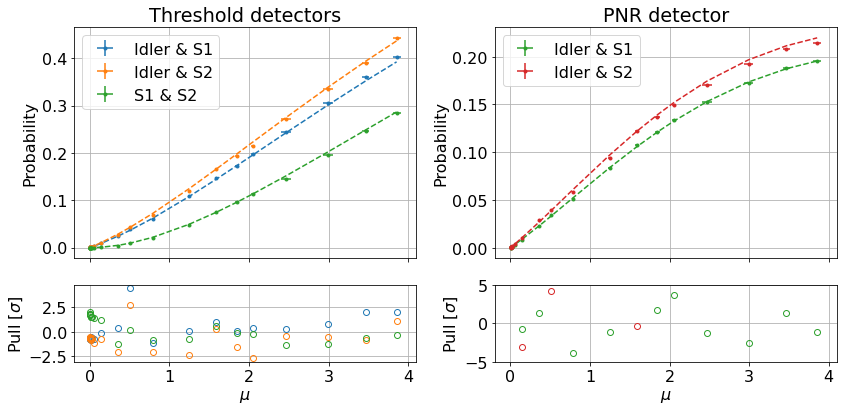

In [107]:
plotTwofold(fr=FitResults())